# Xử lí và trực quan hóa dataset diabetes

## Xử lí 

### Nhập thư viện

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
import warnings
warnings.filterwarnings('ignore') 

### Đọc file và thể hiện 5 dòng đầu 

In [ ]:
data = pd.read_excel("diabetes.xlsx")
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2288.000,33,1


#### Thông tin dữ liệu 
+ có 768 hàng 
+ có 9 cột 

In [3]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

### Trực quan hóa số lượng và tỷ lệ người khỏe mạnh và người mắc tiểu đường trong tập dữ liệu

In [4]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
target_count()
target_percent()

#### Outcome biểu diễn cho ca bệnh 
+ chia outcome = 0 không bị bệnh , outcome = 1 bị bệnh tiểu đường
+ biểu đồ 1 cho thấy 268 người bị bệnh và 500 không bị bệnh 
+ biểu đồ 2 cho ta thấy sự phân bố giữa bị bệnh và không bị bệnh

### Thay thế giá trị 0 bất hợp lý bằng NaN trong các cột y tế liên quan

In [5]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

### Trực quan hóa số lượng và tỷ lệ phần trăm giá trị thiếu trong tập dữ liệu

In [6]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    
# Plotting 
missing_plot(data, 'Outcome')

#### Cột Glucose, BloodPressure, SkinThickness, Insulin, và BMI đã có một số giá trị 0 bị thay bằng NaN.

+ Biểu đồ này sẽ hiển thị:

+ Số lượng giá trị còn lại (không thiếu) trên trục Y

+ Tỷ lệ % giá trị bị thiếu được hiển thị trực tiếp trên từng cột

+ Các cột sẽ được hiển thị theo thứ tự tên trên trục X

+ Cột nào có % missing cao (ví dụ: Insulin, SkinThickness) ⇒ cần xử lý cẩn thận

+ Có thể dùng các kỹ thuật: điền trung vị (median), mô hình dự đoán (imputation), hoặc loại bỏ cột nếu thiếu quá nhiều.

+ Cột nào có tỷ lệ thiếu thấp hoặc không có missing (ví dụ Glucose, BloodPressure) ⇒ có thể xử lý đơn giản hơn.

### Biểu đồ Boxplot – Tổng quan phân phối và ngoại lệ của các biến số

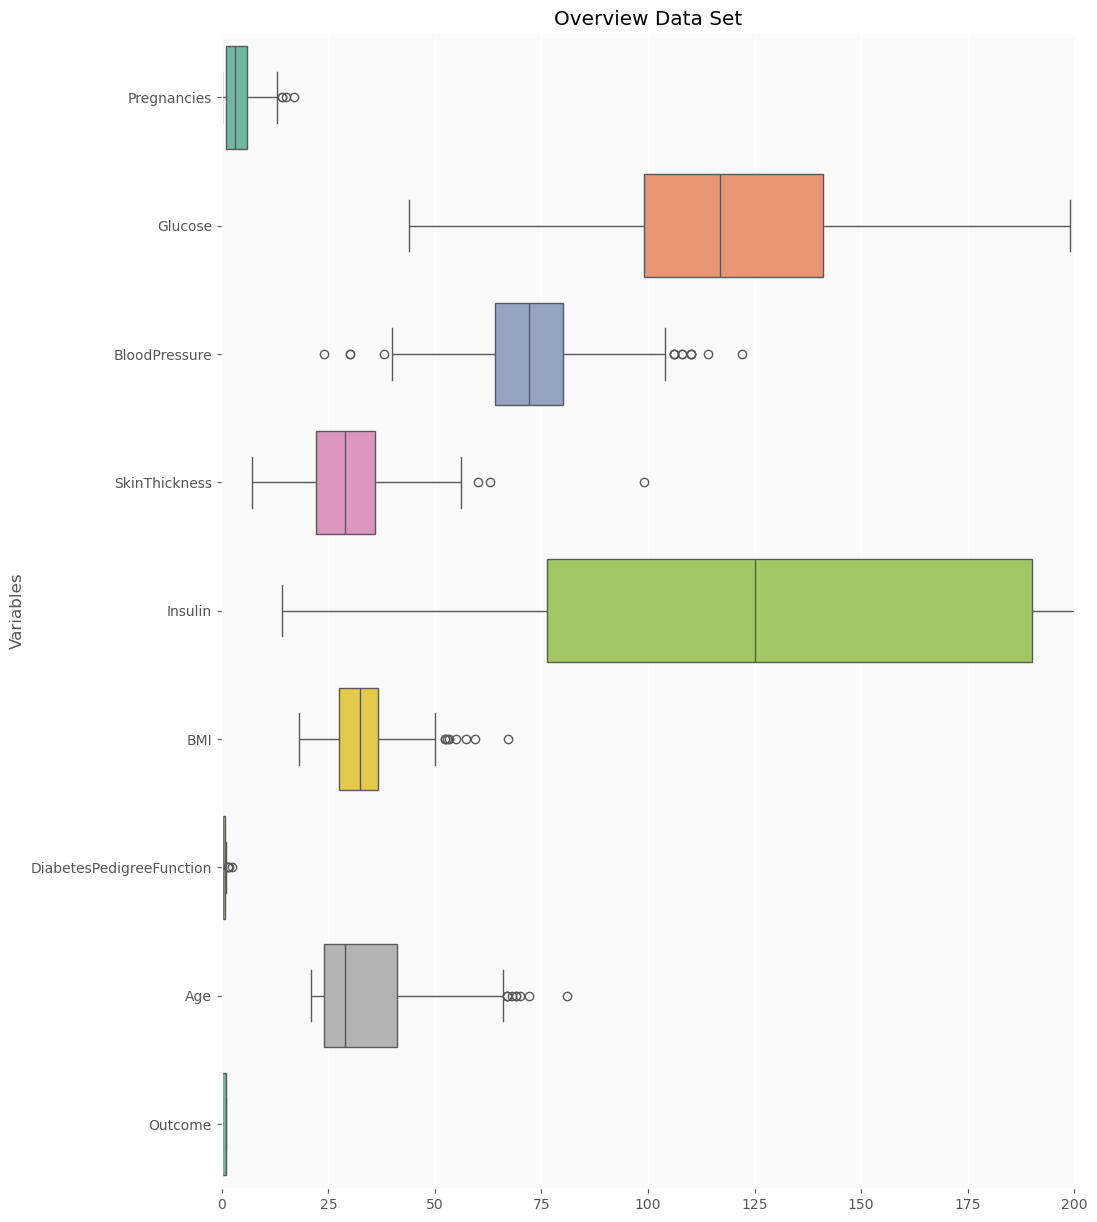

In [7]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

#### Kết luận  
+ Insulin có phân phối rất lệch với nhiều ngoại lệ nằm xa — cho thấy dữ liệu rải rác, không ổn định, nhiều trường hợp cực đoan (có thể do thiếu hoặc đo không chính xác).

+ SkinThickness cũng có nhiều ngoại lệ, tập trung giá trị ở mức thấp, cho thấy biến này có thể ít thông tin hoặc bị thiếu nhiều, cần xem xét kỹ trước khi đưa vào mô hình.

+ BloodPressure có vài ngoại lệ ở phía thấp, phần lớn dữ liệu tập trung trong khoảng hợp lý (~60–90), cho thấy tương đối ổn định nhưng vẫn cần xử lý các giá trị thấp bất thường (vì 0 đã được thay bằng NaN rồi).

+ BMI có phân phối tương đối đều, một vài ngoại lệ ở phía cao (~50+), tuy nhiên vẫn giữ được độ tập trung, cho thấy đây là biến khá ổn định và hữu ích.

+ Glucose có phân phối rộng, một vài ngoại lệ, tuy nhiên phần lớn dữ liệu tập trung trong vùng giá trị hợp lý (~100–150). Đây là biến rất quan trọng vì liên quan trực tiếp đến tiểu đường.

+ Pregnancies là biến rời rạc, có vài giá trị cao bất thường (>15 lần mang thai), nhưng phần lớn dữ liệu nằm dưới 10. Những ngoại lệ này có thể giữ lại nếu hợp lý, nhưng cũng cần kiểm tra lại độ tin cậy.

+ Age có một số ngoại lệ phía cao (trên 70), nhưng phần lớn dữ liệu nằm trong khoảng 20–50 tuổi, phù hợp với dân số nữ trưởng thành.

### Heatmap ma trận tương quan giữa các biến trong tập dữ liệu

In [23]:
def correlation_plot(height  = 2000,width   = 2000):
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)
correlation_plot()

#### Kết luận 
+ Các mối tương quan nổi bật:

+ Glucose ↔ Outcome:

  + Có tương quan dương mạnh (~0.47) với biến mục tiêu Outcome
  + ⇒ Glucose là biến quan trọng nhất trong việc dự đoán bệnh tiểu đường.

+ BMI ↔ Outcome:

  + Có tương quan dương vừa (~0.31) với Outcome
  + ⇒ Chỉ số BMI cũng là yếu tố đáng kể – người béo có khả năng mắc tiểu đường cao hơn.

+ Age ↔ Outcome:

  + Tương quan dương nhẹ (~0.23)
  + ⇒ Tuổi càng cao, nguy cơ mắc tiểu đường càng tăng, nhưng không quá rõ rệt.

+ Pregnancies ↔ Outcome:

  + Cũng có tương quan dương nhẹ (~0.22)
  + ⇒ Số lần mang thai có liên hệ với khả năng mắc tiểu đường – có thể liên quan đến tiểu đường thai kỳ.

+ Tương quan giữa các biến đầu vào với nhau:

+ Insulin ↔ SkinThickness (~0.44):
  + ⇒ Có thể là do liên quan đến khả năng điều tiết đường và chất béo dưới da.

+ Insulin ↔ BMI (~0.19) và SkinThickness ↔ BMI (~0.39)
  + ⇒ Người có BMI cao thường có lớp da dày và chỉ số insulin cao hơn.

+ Glucose ↔ BMI (~0.22)
  + ⇒ Mối liên hệ nhẹ, hợp lý với sinh lý học: người béo dễ có đường huyết cao.

### Tính giá trị trung vị của một biến theo nhóm Outcome

In [17]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

### Biểu đồ phân phối (density plot) của biến Insulin theo nhóm sức khỏe

In [19]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')
plot_distribution('Insulin', 0)

#### Thông tin nổi bật từ biểu đồ phân phối Insulin:

+ Người mắc tiểu đường (diabetic) có xu hướng giá trị Insulin cao hơn so với người khỏe mạnh:

+ Đỉnh phân phối (mode) của nhóm diabetic thường nằm ở phía phải (Insulin cao hơn).

+ Điều này phản ánh sự rối loạn chuyển hóa insulin, đặc trưng của bệnh tiểu đường.

+ Nhóm khỏe mạnh (healthy) có phân phối lệch trái:

+ Phần lớn các giá trị Insulin tập trung ở mức thấp hơn (thường < 100).

+ Một phần do nhiều giá trị bị thiếu hoặc thấp bất thường (sau khi đã xử lý 0 → NaN).

+ Phân phối của cả hai nhóm đều rất rộng và không đối xứng, cho thấy biến Insulin có:

+ Nhiều giá trị ngoại lệ và cực đoan

+ Phân phối không chuẩn (non-normal) ⇒ có thể cần chuẩn hóa hoặc log-transform trước khi dùng cho mô hình

### So sánh giá trị trung vị Insulin giữa người khỏe mạnh và người mắc tiểu đường

In [24]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


### Điền giá trị trung vị Insulin theo nhóm Outcome cho các giá trị bị thiếu

In [25]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

### Biểu đồ phân phối Glucose theo nhóm sức khỏe (diabetic vs healthy)

In [26]:
plot_distribution('Glucose', 0)

#### Kết luận  
+ Người mắc tiểu đường (diabetic) có mức Glucose tập trung ở các giá trị cao hơn so với nhóm khỏe mạnh.

+ Nhóm khỏe mạnh (healthy) có phân phối tập trung ở mức Glucose thấp hơn, hầu hết dưới khoảng 140.

+ Phân phối Glucose ở nhóm tiểu đường cũng khá rộng, nhưng rõ ràng bị dịch sang bên phải (giá trị cao hơn).

+ Điều này phản ánh Glucose là chỉ số quan trọng và có khả năng phân biệt rõ ràng hai nhóm.

### So sánh giá trị trung vị Glucose theo nhóm Outcome cho các giá trị bị thiếu

In [ ]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


### Điền giá trị trung vị Glucose theo nhóm Outcome cho các giá trị bị thiếu

In [28]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

### Biểu đồ phân phối SkinThickness theo nhóm sức khỏe (diabetic vs healthy)

In [29]:
plot_distribution('SkinThickness', 10)

#### Kết luận 
+ Cả hai nhóm (diabetic và healthy) đều có phân phối tập trung ở các giá trị thấp của SkinThickness.

+ Nhóm tiểu đường (diabetic) có xu hướng có giá trị SkinThickness cao hơn một chút so với nhóm khỏe mạnh, nhưng sự khác biệt không quá rõ rệt.

+ Phân phối khá dày ở mức thấp, với nhiều giá trị nằm gần 0, cho thấy biến này có nhiều điểm tập trung thấp hoặc có thể bị thiếu dữ liệu (đã thay 0 bằng NaN trước đó).

+ Biến này có vẻ không phân tách nhóm rõ ràng như Glucose hay Insulin, nên có thể ít ảnh hưởng hơn trong dự đoán.

### So sánh giá trị trung vị SkinThickness giữa người khỏe mạnh và người mắc tiểu đường

In [30]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


###  Điền giá trị trung vị SkinThickness theo nhóm Outcome cho các giá trị bị thiếu

In [31]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

### Biểu đồ phân phối BloodPressure theo nhóm sức khỏe (diabetic vs healthy)

In [32]:
plot_distribution('BloodPressure', 5)

#### Kết luận  
+ Phân phối BloodPressure của cả hai nhóm (diabetic và healthy) khá giống nhau, với phần lớn giá trị tập trung ở khoảng từ 60 đến 90.

+ Nhóm tiểu đường có xu hướng có giá trị huyết áp cao hơn một chút, nhưng sự khác biệt không lớn và không rõ ràng như các biến Glucose hay Insulin.

+ Có một vài ngoại lệ và giá trị thấp nằm ngoài vùng tập trung chính, tuy nhiên số lượng không nhiều.

+ Biến này có thể có tác động nhỏ đến việc phân biệt hai nhóm, nhưng không phải là biến đặc trưng mạnh.

### So sánh giá trị trung vị BloodPressure giữa người khỏe mạnh và người mắc tiểu đường

In [35]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


###  Điền giá trị trung vị BloodPressure theo nhóm Outcome cho các giá trị bị thiếu

In [36]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

### Biểu đồ phân phối BMI theo nhóm sức khỏe (diabetic vs healthy)

In [37]:
plot_distribution('BMI', 0)

#### kết luận 
+ Người mắc tiểu đường (diabetic) có xu hướng phân phối BMI dịch chuyển về phía các giá trị cao hơn so với nhóm khỏe mạnh (healthy).

+ Nhóm khỏe mạnh có phân phối BMI tập trung ở mức thấp hơn và ít giá trị BMI cao.

+ Sự khác biệt này cho thấy BMI là một biến quan trọng, liên quan đến nguy cơ mắc tiểu đường.

+ Phân phối BMI ở cả hai nhóm khá đồng đều và không quá nhiều ngoại lệ rõ rệt.

### So sánh giá trị trung vị BMI giữa người khỏe mạnh và người mắc tiểu đường

In [38]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


### Điền giá trị trung vị BMI theo nhóm Outcome cho các giá trị bị thiếu

In [39]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

### Biểu đồ phân phối các nhóm còn lại theo nhóm sức khỏe (diabetic vs healthy)

In [40]:
#plot distribution 
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

#### Kết luận 
+ nhóm Age :
  + Nhóm mắc tiểu đường (diabetic) có xu hướng có tuổi cao hơn so với nhóm khỏe mạnh.

  + Phân phối tuổi của nhóm tiểu đường dãn rộng hơn, với nhiều người lớn tuổi hơn xuất hiện trong nhóm này.

  + Nhóm khỏe mạnh (healthy) tập trung nhiều ở độ tuổi trẻ hơn.

  + Điều này phản ánh rằng tuổi cao hơn là một yếu tố rủi ro liên quan đến khả năng mắc tiểu đường.
+ Nhóm Pregnancies :
  + Nhóm mắc tiểu đường (diabetic) có xu hướng có số lần mang thai cao hơn so với nhóm khỏe mạnh.

  + Phân phối của nhóm tiểu đường dãn rộng hơn, với nhiều người có số lần mang thai lớn hơn 5 lần.

  + Nhóm khỏe mạnh tập trung nhiều hơn ở các giá trị nhỏ (0–3 lần mang thai).

  + Điều này cho thấy số lần mang thai có thể là một yếu tố liên quan đến nguy cơ mắc tiểu đường, có thể do ảnh hưởng của tiểu đường thai kỳ hoặc các yếu tố liên quan.
+ Nhóm DiabetesPedigreeFunction :
  + Nhóm mắc tiểu đường (diabetic) có xu hướng có giá trị DiabetesPedigreeFunction cao hơn so với nhóm khỏe mạnh.

  + Phân phối ở nhóm tiểu đường dãn rộng hơn và dịch sang phải, thể hiện mức độ liên quan di truyền hoặc nguy cơ gia đình cao hơn.

  + Nhóm khỏe mạnh tập trung nhiều ở giá trị thấp hơn, thể hiện ít nguy cơ di truyền hơn.

  + Biến này thể hiện mối liên hệ di truyền hoặc gia đình với bệnh tiểu đường và có thể giúp phân biệt các nhóm hiệu quả.

### Biểu đồ kiểm tra và trực quan hóa các giá trị bị thiếu trong tập dữ liệu

In [41]:
missing_plot(data, 'Outcome')

#### Biểu đồ cho thấy số lượng và tỷ lệ phần trăm các giá trị bị thiếu (NaN) trong từng biến của tập dữ liệu.

+ Các biến như Glucose, BloodPressure, SkinThickness, Insulin, BMI có một lượng giá trị bị thiếu đáng kể do các giá trị 0 đã được thay bằng NaN trước đó.

+ Biến Insulin thường có lượng giá trị thiếu nhiều nhất, phản ánh đặc điểm dữ liệu đo lường khó hoặc thiếu sót trong thu thập.

+ Biến Outcome không có giá trị thiếu, đảm bảo dữ liệu mục tiêu đầy đủ.

+ Việc trực quan hóa này giúp xác định các biến cần được xử lý hoặc điền giá trị để không ảnh hưởng đến mô hình dự đoán.

### Biểu đồ phân tán (scatter plot) so sánh hai biến theo nhóm sức khỏe

In [42]:
def plot_feat1_feat2(feat1, feat2) :  
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

### Biểu đồ thanh kết hợp với đường thể hiện tỷ lệ phần trăm người mắc tiểu đường theo biến phân loại

In [45]:
def barplot(var_select, sub) :
    tmp1 = data[(data['Outcome'] != 0)]
    tmp2 = data[(data['Outcome'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Outcome']), )
    tmp3['% diabetic'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='diabetic',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='healthy', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['% diabetic'],
        yaxis = 'y2',
        name='% diabetic', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% diabetic'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

### Biểu đồ Pie thể hiện phân bố biến theo nhóm mục tiêu (Diabetic vs Healthy)

In [ ]:
def plot_pie(var_select, sub) :
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    
    col =['Silver', 'mediumturquoise','#CF5C36','lightblue','magenta', '#FF5D73','#F2D7EE','mediumturquoise']
    
    trace1 = go.Pie(values  = D[var_select].value_counts().values.tolist(),
                    labels  = D[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Diabetic",
                    marker  = dict(colors = col, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = H[var_select].value_counts().values.tolist(),
                    labels  = H[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Healthy" )

    layout = go.Layout(dict(title = var_select + " distribution by target <br>"+(sub),
                            annotations = [ dict(text = "Diabetic"+" : "+"268",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "Healthy"+" : "+"500",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

### Biểu đồ phân tán Glucose và Age theo nhóm sức khỏe (diabetic vs healthy)

In [47]:
plot_feat1_feat2('Glucose','Age')

#### Kết luận 
+ Người mắc tiểu đường (diabetic) thường tập trung ở vùng có Glucose cao và tuổi lớn hơn.

+ Nhóm khỏe mạnh (healthy) phân bố chủ yếu ở vùng Glucose thấp và độ tuổi trẻ hơn.

+ Có sự phân tách khá rõ ràng giữa hai nhóm khi kết hợp hai biến này, cho thấy Glucose và Age cùng nhau là chỉ số mạnh để phân biệt sức khỏe.

+ Một số điểm ngoại lệ ở giữa, nhưng xu hướng chung thể hiện mối liên hệ giữa tuổi, lượng glucose và nguy cơ tiểu đường.

### Biểu đồ scatterplot Glucose và Age với phân loại Outcome (diabetic vs healthy) và vùng quan tâm được đánh dấu

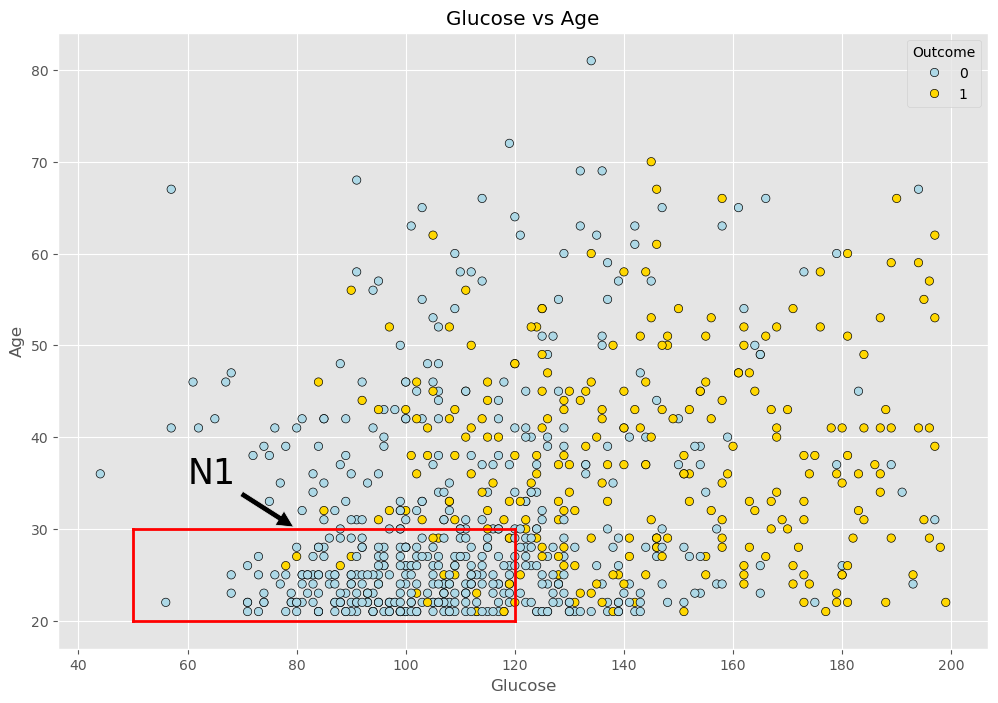

In [48]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N1', size=25, color='black', xy=(80, 30), xytext=(60, 35),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([50, 120], [30, 30], linewidth=2, color = 'red')
plt.plot([120, 120], [20, 30], linewidth=2, color = 'red')
plt.plot([50, 120], [20, 20], linewidth=2, color = 'red')
plt.plot([50, 50], [20, 30], linewidth=2, color = 'red')
plt.title('Glucose vs Age')
plt.show()

#### Kết luận 
+ Biểu đồ scatterplot thể hiện sự phân bố của hai nhóm Outcome theo hai biến Glucose (trục x) và Age (trục y), với màu sắc khác nhau:

  + Nhóm khỏe mạnh (Outcome=0) màu xanh da trời (lightblue)

  + Nhóm tiểu đường (Outcome=1) màu vàng (gold)

  + Vùng được đánh dấu bởi khung đỏ là khu vực có giá trị Glucose từ 50 đến 120 và tuổi từ 20 đến 30 (khoảng vùng N1).

  + Vùng này có sự tập trung khá lớn của những người khỏe mạnh.

+ Ý nghĩa vùng này có thể là khu vực an toàn, nơi người có mức glucose và tuổi trong khoảng này ít nguy cơ tiểu đường.

  + Mũi tên và nhãn N1 giúp thu hút sự chú ý vào khu vực này để phân tích hoặc so sánh thêm.

  + Biểu đồ cho thấy rõ ràng rằng nhóm tiểu đường có xu hướng tập trung ở vùng Glucose cao hơn và độ tuổi đa dạng hơn.

### Tạo biến nhị phân N1 đánh dấu nhóm có Age ≤ 30 và Glucose ≤ 120

In [49]:
data.loc[:,'N1']=0
data.loc[(data['Age']<=30) & (data['Glucose']<=120),'N1']=1

### Biểu đồ thanh và tỷ lệ phần trăm người mắc tiểu đường theo nhóm N1 (Glucose ≤ 120 và Age ≤ 30)

In [50]:
barplot('N1', ':Glucose <= 120 and Age <= 30')

#### Kết luận  
+ Nhóm N1 = 1 (tuổi ≤ 30 và glucose ≤ 120) có tỷ lệ phần trăm người mắc tiểu đường thấp hơn rất nhiều so với nhóm N1 = 0.

+ Điều này xác nhận vùng an toàn (N1) là vùng có nguy cơ tiểu đường thấp.

+ Số lượng người khỏe mạnh trong nhóm N1 chiếm ưu thế rõ rệt, cho thấy nhóm này có thể được xem là nhóm nguy cơ thấp.

+ Ngược lại, nhóm N1 = 0 (ngoài vùng an toàn) có tỷ lệ mắc tiểu đường cao hơn, phản ánh nguy cơ lớn hơn.

### Biểu đồ Pie phân bố biến N1 theo nhóm mục tiêu (Diabetic vs Healthy)

In [51]:
plot_pie('N1', '(Glucose <= 120 and Age <= 30)')

#### Kết luận 
+ Biểu đồ cho thấy tỷ lệ các giá trị của biến N1 trong từng nhóm:

  + Nhóm Diabetic (mắc tiểu đường)

  + Nhóm Healthy (khỏe mạnh)

+ Giá trị N1 = 1 (Glucose ≤ 120 và Age ≤ 30) chiếm phần lớn trong nhóm khỏe mạnh, minh chứng vùng này là nhóm nguy cơ thấp.

+ Ngược lại, nhóm mắc tiểu đường có phần lớn giá trị N1 = 0, nghĩa là nằm ngoài vùng an toàn này.

+ Sự phân bố rõ ràng này giúp khẳng định vai trò của biến N1 trong việc phân biệt rủi ro tiểu đường.  

### Tạo biến nhị phân N2 đánh dấu nhóm có BMI ≤ 30

In [52]:
data.loc[:,'N2']=0
data.loc[(data['BMI']<=30),'N2']=1

### Biểu đồ thanh và tỷ lệ phần trăm người mắc tiểu đường theo nhóm N2 (BMI ≤ 30)

In [53]:
barplot('N2', ': BMI <= 30')

#### Kết luận 
+ Nhóm N2 = 1 (có BMI ≤ 30) chiếm phần lớn trong nhóm khỏe mạnh, cho thấy chỉ số BMI trong giới hạn này có liên quan đến nguy cơ thấp hơn với tiểu đường.

+ Nhóm N2 = 0 (BMI > 30) có tỷ lệ mắc tiểu đường cao hơn, phản ánh nguy cơ béo phì liên quan đến bệnh tiểu đường.

+ Biểu đồ thể hiện rõ sự khác biệt phân bố và tỷ lệ mắc tiểu đường giữa hai nhóm dựa trên chỉ số BMI.

### Biểu đồ Pie phân bố biến N2 theo nhóm mục tiêu (Diabetic vs Healthy)

In [54]:
plot_pie('N2', 'BMI <= 30')

#### Kết luận 

+ Biểu đồ thể hiện sự phân bố các giá trị của biến N2 trong hai nhóm:

  + Nhóm mắc tiểu đường (Diabetic)

  + Nhóm khỏe mạnh (Healthy)

+ Giá trị N2 = 1 (BMI ≤ 30) chiếm tỷ lệ lớn trong nhóm khỏe mạnh, khẳng định BMI trong giới hạn này tương ứng với nguy cơ tiểu đường thấp hơn.

+ Ngược lại, nhóm mắc tiểu đường có tỷ lệ lớn hơn ở giá trị N2 = 0 (BMI > 30), phản ánh liên quan giữa béo phì và tiểu đường.

+ Sự phân bố rõ ràng này hỗ trợ cho việc sử dụng biến N2 như một đặc trưng trong phân tích hoặc mô hình dự báo.

### Biểu đồ phân tán giữa số lần mang thai (Pregnancies) và tuổi (Age) theo nhóm sức khỏe (diabetic vs healthy)

In [55]:
plot_feat1_feat2('Pregnancies','Age')

####  Kết luận 
+ Nhóm mắc tiểu đường (diabetic) có xu hướng tập trung ở những người có tuổi cao hơn và số lần mang thai nhiều hơn.

+ Nhóm khỏe mạnh (healthy) tập trung ở vùng có tuổi trẻ hơn và ít lần mang thai hơn.

+ Biểu đồ cho thấy mối liên hệ giữa số lần mang thai và tuổi tác có thể ảnh hưởng đến nguy cơ mắc tiểu đường.

+ Hai biến này khi kết hợp có thể giúp phân biệt tương đối rõ ràng giữa hai nhóm bệnh nhân.

### Biểu đồ scatterplot Pregnancies và Age với phân loại Outcome và vùng quan tâm được đánh dấu (N3)

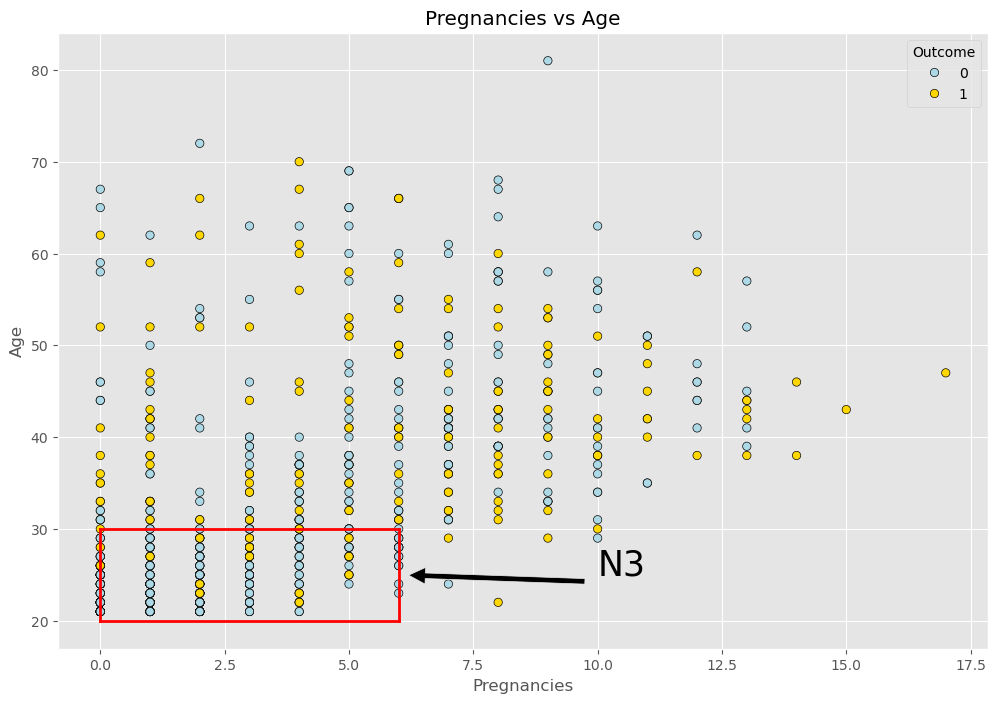

In [56]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Pregnancies'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N3', size=25, color='black', xy=(6, 25), xytext=(10, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 6], [30, 30], linewidth=2, color = 'red')
plt.plot([6, 6], [20, 30], linewidth=2, color = 'red')
plt.plot([0, 6], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 30], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

#### Kết luận 
+ Vùng được khoanh đỏ (N3) thể hiện nhóm người có:

  + Số lần mang thai từ 0 đến 6

  + Tuổi từ 20 đến 30

+ Trong vùng N3 này, đa phần điểm dữ liệu là nhóm khỏe mạnh (Outcome=0, màu xanh da trời).

+ Nhóm tiểu đường (Outcome=1, màu vàng) tập trung nhiều hơn ở các vùng ngoài N3, đặc biệt ở số lần mang thai cao hơn hoặc tuổi lớn hơn.

+ Điều này cho thấy rằng những người trẻ (20-30 tuổi) với số lần mang thai không quá 6 thường có nguy cơ tiểu đường thấp hơn.

+ Mũi tên và nhãn N3 giúp làm nổi bật khu vực an toàn hoặc nhóm đặc trưng để phân tích thêm.

### Tạo biến nhị phân N3 đánh dấu nhóm có Age ≤ 30 và Pregnancies ≤ 6

In [57]:
data.loc[:,'N3']=0
data.loc[(data['Age']<=30) & (data['Pregnancies']<=6),'N3']=1

### Biểu đồ thanh và tỷ lệ phần trăm người mắc tiểu đường theo nhóm N3 (Age ≤ 30 và Pregnancies ≤ 6)

In [58]:
barplot('N3', ': Age <= 30 and Pregnancies <= 6')

#### Kết luận 
+ Nhóm N3 = 1 (tuổi ≤ 30 và số lần mang thai ≤ 6) có tỷ lệ mắc tiểu đường thấp hơn rõ rệt so với nhóm N3 = 0.

+ Phần lớn người trong nhóm N3=1 là khỏe mạnh, thể hiện nhóm này thuộc vùng nguy cơ thấp.

+ Ngược lại, nhóm ngoài vùng này (N3=0) có tỷ lệ mắc tiểu đường cao hơn nhiều.

+ Kết quả này hỗ trợ giả thuyết rằng người trẻ tuổi với số lần mang thai không cao có nguy cơ tiểu đường thấp hơn.

### Biểu đồ Pie phân bố biến N3 theo nhóm mục tiêu (Diabetic vs Healthy)

In [59]:
plot_pie('N3', 'Age <= 30 and Pregnancies <= 6')

#### Kết luận 
+ Biểu đồ thể hiện tỷ lệ phân bố giá trị N3 trong hai nhóm:

  + Nhóm mắc tiểu đường (Diabetic)

  + Nhóm khỏe mạnh (Healthy)

+ Giá trị N3 = 1 (tuổi ≤ 30 và số lần mang thai ≤ 6) chiếm phần lớn trong nhóm khỏe mạnh, chứng tỏ nhóm này có nguy cơ thấp.

+ Ngược lại, nhóm mắc tiểu đường có tỷ lệ cao hơn ở N3 = 0 (người ngoài vùng này), xác nhận nguy cơ cao hơn.

+ Sự phân bố rõ ràng này cho thấy biến N3 có thể là chỉ số phân loại tốt trong việc đánh giá nguy cơ tiểu đường.

### Biểu đồ phân tán giữa Glucose và BloodPressure phân theo nhóm sức khỏe (Diabetic vs Healthy)

In [60]:
plot_feat1_feat2('Glucose','BloodPressure')

#### Kết luận 
+ Nhóm mắc tiểu đường (diabetic) thường có mức Glucose cao hơn rõ rệt so với nhóm khỏe mạnh.

+ Áp lực máu (BloodPressure) phân bố khá đa dạng ở cả hai nhóm, nhưng không có sự phân biệt quá rõ ràng giữa nhóm mắc tiểu đường và nhóm khỏe mạnh dựa trên BloodPressure.

+ Mối liên hệ giữa Glucose và BloodPressure không quá mạnh, tuy nhiên, giá trị Glucose vẫn là biến đặc trưng quan trọng trong phân biệt nhóm bệnh nhân.

+ Biểu đồ giúp minh họa sự khác biệt trong mức Glucose giữa hai nhóm, trong khi BloodPressure có thể cần phân tích thêm hoặc kết hợp với biến khác để dự báo hiệu quả hơn.

### Biểu đồ scatterplot giữa Glucose và BloodPressure với vùng quan tâm N4 được khoanh đỏ

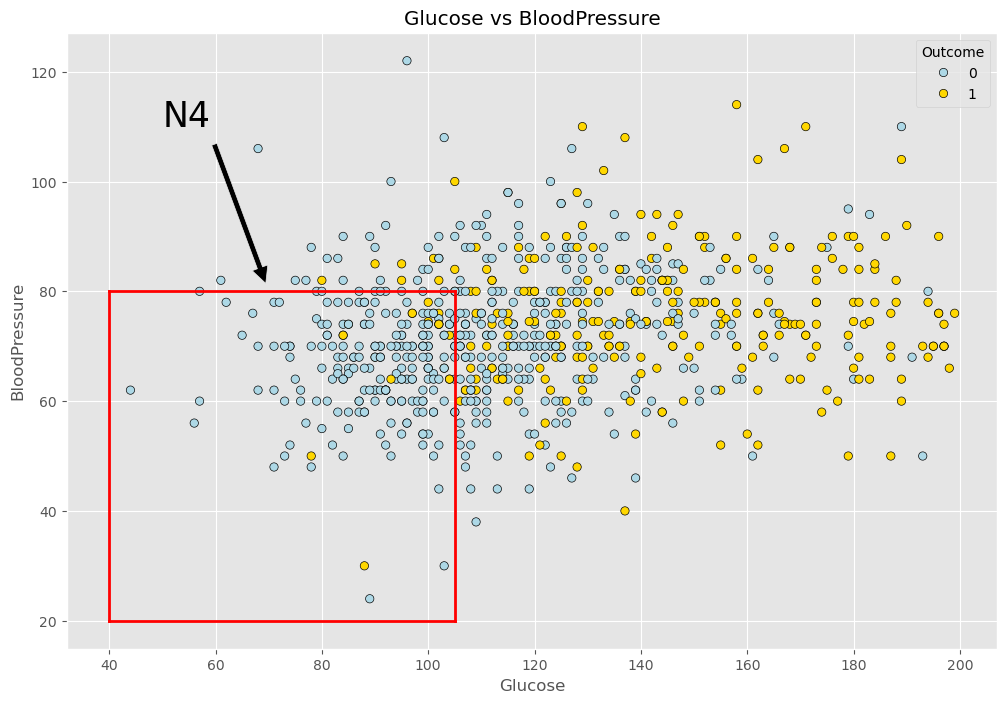

In [61]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BloodPressure'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N4', size=25, color='black', xy=(70, 80), xytext=(50, 110),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([40, 105], [80, 80], linewidth=2, color = 'red')
plt.plot([40, 40], [20, 80], linewidth=2, color = 'red')
plt.plot([40, 105], [20, 20], linewidth=2, color = 'red')
plt.plot([105, 105], [20, 80], linewidth=2, color = 'red')
plt.title('Glucose vs BloodPressure')
plt.show()

#### Kết luận 
+ Vùng khoanh đỏ N4 đại diện cho khu vực có:

  + Glucose từ 40 đến 105

  + BloodPressure từ 20 đến 80

+ Trong vùng N4 này, phần lớn điểm dữ liệu thuộc nhóm khỏe mạnh (Outcome = 0, màu xanh dương).

+ Nhóm mắc tiểu đường (Outcome = 1, màu vàng) có xu hướng phân bố nhiều ở ngoài vùng N4, đặc biệt ở mức Glucose cao hơn.

+ Điều này cho thấy người có Glucose và BloodPressure nằm trong vùng N4 có khả năng thấp hơn về nguy cơ tiểu đường.

+ Vùng N4 có thể được dùng để tạo biến phân loại hoặc nhóm người có nguy cơ thấp.

### Tạo biến nhị phân N4 đánh dấu nhóm có Glucose ≤ 105 và BloodPressure ≤ 80

In [62]:
data.loc[:,'N4']=0
data.loc[(data['Glucose']<=105) & (data['BloodPressure']<=80),'N4']=1

### Biểu đồ thanh và tỷ lệ phần trăm mắc tiểu đường theo nhóm N4 (Glucose ≤ 105 và BloodPressure ≤ 80)

In [63]:
barplot('N4', ': Glucose <= 105 and BloodPressure <= 80')

#### Kết luận 
+ Nhóm N4 = 1 (Glucose ≤ 105 và BloodPressure ≤ 80) có tỷ lệ mắc tiểu đường thấp hơn nhóm N4 = 0 rất rõ ràng.

+ Số lượng người khỏe mạnh trong nhóm N4=1 chiếm đa số, cho thấy nhóm này thuộc vùng nguy cơ thấp.

+ Ngược lại, nhóm N4=0 chứa nhiều người mắc tiểu đường hơn, phản ánh nguy cơ cao hơn khi Glucose hoặc BloodPressure vượt ngưỡng đã định.

+ Kết quả này củng cố vai trò của Glucose và BloodPressure trong dự báo nguy cơ tiểu đường.

### Biểu đồ Pie phân bố biến N4 theo nhóm mục tiêu (Diabetic vs Healthy)

In [64]:
plot_pie('N4', 'Glucose <= 105 and BloodPressure <= 80')

#### Kết luận 
+ Biểu đồ cho thấy tỷ lệ phân bố giá trị N4 trong hai nhóm:

  + Nhóm mắc tiểu đường (Diabetic)

  + Nhóm khỏe mạnh (Healthy)

+ Trong nhóm N4 = 1 (Glucose ≤ 105 và BloodPressure ≤ 80), phần lớn là người khỏe mạnh, thể hiện nhóm này có nguy cơ tiểu đường thấp.

+ Nhóm N4 = 0 có tỷ lệ mắc tiểu đường cao hơn, phù hợp với kỳ vọng vùng nguy cơ cao hơn.

+ Sự phân bố rõ ràng này khẳng định biến N4 là một chỉ số phân loại hiệu quả dựa trên hai yếu tố Glucose và BloodPressure.

### Tạo biến nhị phân N5 đánh dấu nhóm có SkinThickness ≤ 20

In [65]:
data.loc[:,'N5']=0
data.loc[(data['SkinThickness']<=20) ,'N5']=1

### Biểu đồ thanh và tỷ lệ phần trăm mắc tiểu đường theo nhóm N5 (SkinThickness ≤ 20)

In [66]:
barplot('N5', ':SkinThickness <= 20')

#### Kết luận 
+ Nhóm N5 = 1 (SkinThickness ≤ 20) chiếm đa số ở cả hai nhóm nhưng có tỷ lệ người mắc tiểu đường thấp hơn so với nhóm N5 = 0.

+ Điều này cho thấy người có độ dày da (SkinThickness) thấp hơn hoặc bằng 20 có xu hướng ít bị tiểu đường hơn.

+ Ngược lại, nhóm N5 = 0 với SkinThickness lớn hơn 20 có tỷ lệ mắc tiểu đường cao hơn, phản ánh nguy cơ tiểu đường có thể tăng theo độ dày da.

+ Biến N5 có thể đóng vai trò quan trọng trong phân tích nguy cơ bệnh tiểu đường.

### Biểu đồ Pie phân bố biến N5 theo nhóm mục tiêu (Diabetic vs Healthy)

In [67]:
plot_pie('N5', 'SkinThickness <= 20')

#### Kết luận 
+ Biểu đồ cho thấy tỷ lệ phần trăm các giá trị của biến N5 trong nhóm bệnh nhân tiểu đường và nhóm khỏe mạnh.

+ Trong nhóm N5 = 1 (SkinThickness ≤ 20), phần lớn là người khỏe mạnh, khẳng định nhóm này có nguy cơ thấp hơn với bệnh tiểu đường.

+ Nhóm N5 = 0 chứa tỷ lệ cao hơn người mắc tiểu đường, phản ánh rằng độ dày da lớn hơn 20 có thể liên quan đến nguy cơ cao hơn.

+ Kết quả này cho thấy biến N5 có thể là một chỉ số phân biệt tốt giữa hai nhóm bệnh.

### Biểu đồ scatterplot thể hiện mối quan hệ giữa SkinThickness và BMI theo nhóm bệnh tiểu đường

In [68]:
plot_feat1_feat2('SkinThickness','BMI')

#### Kết luận 
+ Biểu đồ thể hiện sự phân bố của hai nhóm:

  + Nhóm mắc tiểu đường (màu vàng)

  + Nhóm khỏe mạnh (màu xanh dương)

+ Người mắc tiểu đường thường có chỉ số BMI và độ dày da (SkinThickness) cao hơn so với nhóm khỏe mạnh.

+ Có sự chồng lấn ở vùng BMI trung bình và SkinThickness thấp, nhưng phần lớn điểm dữ liệu bệnh nhân tiểu đường tập trung ở vùng BMI và SkinThickness cao.

+ Mối quan hệ này cho thấy BMI và SkinThickness đều có liên quan đến nguy cơ tiểu đường và có thể được sử dụng cùng nhau để phân loại.

### Tạo biến nhị phân N6 đánh dấu nhóm có BMI < 30 và SkinThickness ≤ 20

In [69]:
data.loc[:,'N6']=0
data.loc[(data['BMI']<30) & (data['SkinThickness']<=20),'N6']=1

### Biểu đồ Scatterplot biểu diễn mối quan hệ giữa SkinThickness và BMI theo nhóm Outcome, với vùng đánh dấu N6

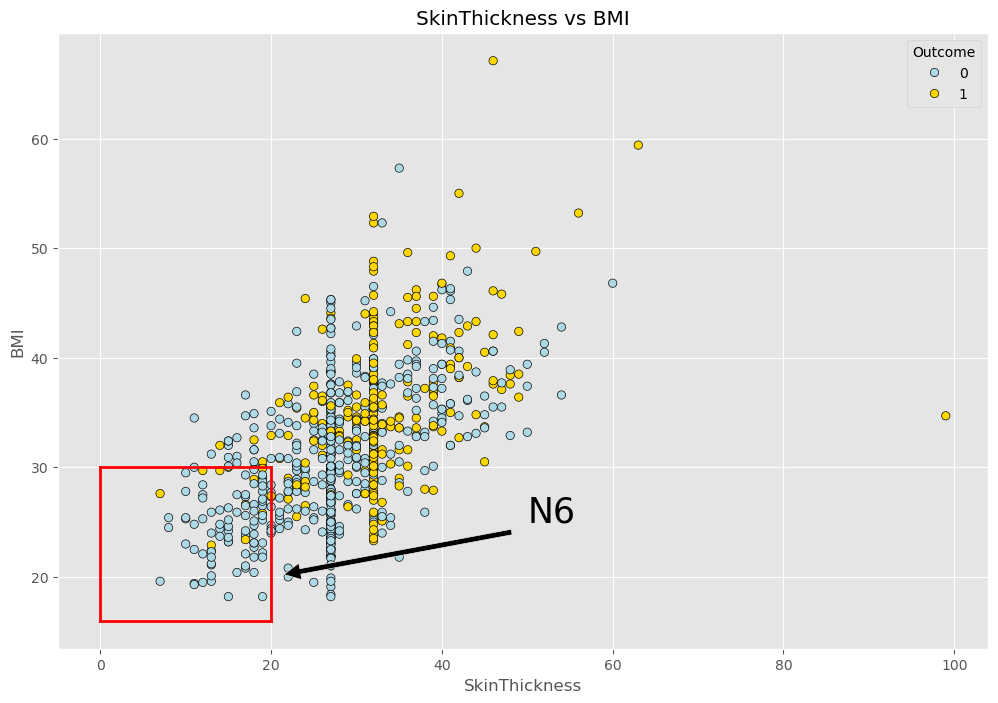

In [70]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['SkinThickness'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N6', size=25, color='black', xy=(20, 20), xytext=(50, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 20], [30, 30], linewidth=2, color = 'red')
plt.plot([0, 0], [16, 30], linewidth=2, color = 'red')
plt.plot([0, 20], [16, 16], linewidth=2, color = 'red')
plt.plot([20, 20], [16, 30], linewidth=2, color = 'red')
plt.title('SkinThickness vs BMI')
plt.show()

####  Kết luận 
+ Vùng N6 được giới hạn bởi:

+ BMI < 30 (đường ngang tại BMI = 30)

+ SkinThickness ≤ 20 (đường dọc tại SkinThickness = 20)

+ Nhóm có điểm trong vùng N6 (góc dưới bên trái) chủ yếu là người khỏe mạnh (màu xanh dương).

+ Những người ngoài vùng này có nguy cơ tiểu đường cao hơn (màu vàng tập trung nhiều hơn).

+ Điều này xác nhận vùng N6 đại diện cho nhóm bệnh nhân có chỉ số BMI và SkinThickness thấp hơn, đồng thời nguy cơ tiểu đường thấp hơn.

### Biểu đồ thanh và tỷ lệ phần trăm mắc tiểu đường theo nhóm N6 (BMI < 30 và SkinThickness ≤ 20)

In [71]:
barplot('N6', ': BMI < 30 and SkinThickness <= 20')

#### Kết luận 
+ Nhóm N6 = 1 (BMI < 30 và SkinThickness ≤ 20) có số lượng bản ghi khá lớn trong cả hai nhóm.

+ Tỷ lệ người mắc tiểu đường trong nhóm N6 = 1 thấp hơn so với nhóm N6 = 0.

+ Điều này cho thấy bệnh nhân với chỉ số BMI thấp hơn 30 và độ dày da nhỏ hơn hoặc bằng 20 có nguy cơ tiểu đường thấp hơn.

+ Ngược lại, nhóm N6 = 0 (BMI ≥ 30 hoặc SkinThickness > 20) có tỷ lệ mắc tiểu đường cao hơn rõ rệt.

### Biểu đồ Pie phân bố biến N6 theo nhóm mục tiêu (Diabetic vs Healthy) với điều kiện BMI < 30 và SkinThickness ≤ 20

In [72]:
plot_pie('N6', 'BMI < 30 and SkinThickness <= 20')

#### Kết luận 
+ Biểu đồ thể hiện tỷ lệ phần trăm phân bố của nhóm bệnh nhân có N6 = 1 và N6 = 0 trong từng nhóm Outcome.

+ Trong nhóm N6 = 1 (BMI < 30 và SkinThickness ≤ 20), phần lớn là người khỏe mạnh, tỷ lệ người tiểu đường thấp.

+ Ngược lại, nhóm N6 = 0 chứa tỷ lệ cao hơn người mắc tiểu đường.

+ Kết quả này củng cố rằng vùng dữ liệu N6 là vùng an toàn, có liên quan mật thiết đến nguy cơ thấp hơn với bệnh tiểu đường.

### Biểu đồ scatterplot thể hiện mối quan hệ giữa Glucose và BMI theo nhóm Outcome

In [73]:
plot_feat1_feat2('Glucose','BMI')

#### Kết luận 
+ Người mắc tiểu đường (màu vàng) có xu hướng có chỉ số Glucose và BMI cao hơn nhóm khỏe mạnh (màu xanh dương).

+ Có sự phân tách tương đối rõ ràng giữa hai nhóm ở vùng Glucose cao và BMI cao.

+ Nhiều điểm dữ liệu của nhóm bệnh tiểu đường tập trung ở phần trên bên phải biểu đồ (Glucose và BMI đều cao).

+ Điều này cho thấy Glucose và BMI là hai biến quan trọng và có ảnh hưởng mạnh đến nguy cơ tiểu đường.

### Scatterplot Glucose vs BMI với vùng giới hạn N7 đánh dấu (Glucose từ 40 đến 105, BMI từ 16 đến 30)

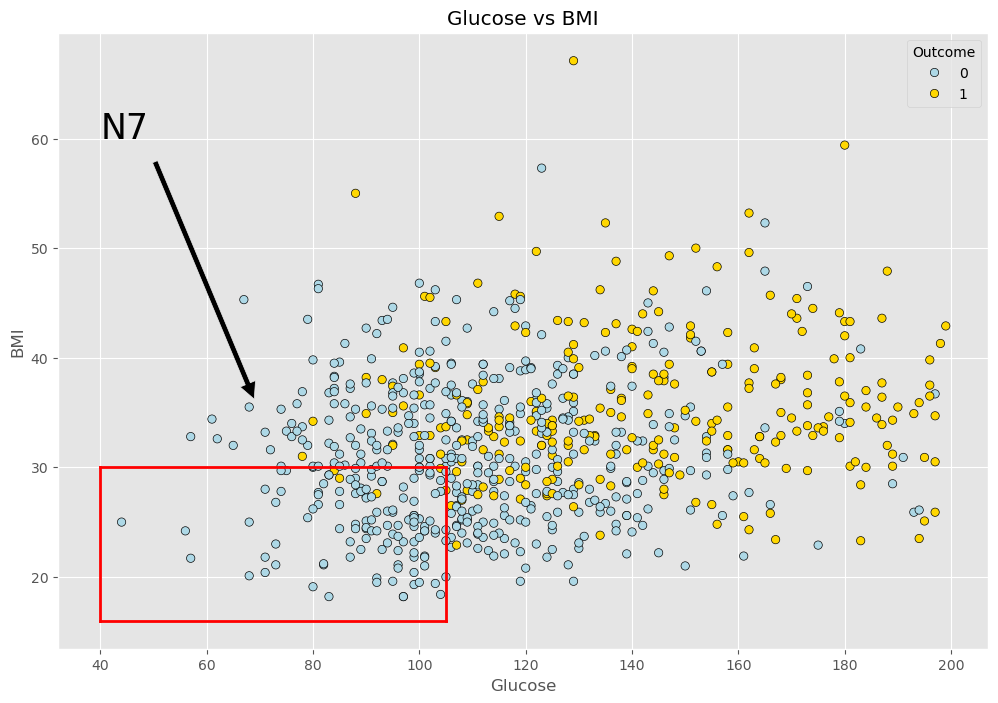

In [74]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N7', size=25, color='black', xy=(70, 35), xytext=(40, 60),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([105, 105], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 40], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 105], [16, 16], linewidth=2, color = 'red')
plt.plot([40, 105], [30, 30], linewidth=2, color = 'red')
plt.title('Glucose vs BMI')
plt.show()

#### Kết luận 
+ Vùng N7 được khoanh đỏ giới hạn:

  + Glucose nằm trong khoảng từ 40 đến 105

  + BMI nằm trong khoảng từ 16 đến 30

+ Hầu hết điểm trong vùng này là người khỏe mạnh (màu xanh dương).

+ Những điểm nằm ngoài vùng này có nguy cơ cao mắc tiểu đường hơn (màu vàng nhiều hơn).

+ Điều này cho thấy vùng N7 tương ứng với nhóm có chỉ số Glucose và BMI vừa phải, đồng thời nguy cơ tiểu đường thấp hơn.

### Tạo biến nhị phân N7: đánh dấu bệnh nhân có Glucose ≤ 105 và BMI ≤ 30

In [75]:
data.loc[:,'N7']=0
data.loc[(data['Glucose']<=105) & (data['BMI']<=30),'N7']=1

### Biểu đồ cột thể hiện phân bố biến N7 theo nhóm Outcome (Diabetic vs Healthy) với điều kiện Glucose ≤ 105 và BMI ≤ 30

In [76]:
barplot('N7', ': Glucose <= 105 and BMI <= 30')

#### Kết luận 
+ Nhóm N7 = 1 (Glucose ≤ 105 và BMI ≤ 30) có số lượng người khỏe mạnh chiếm đa số, trong khi số người tiểu đường ít hơn đáng kể.

+ Ngược lại, nhóm N7 = 0 chứa nhiều người mắc tiểu đường hơn so với nhóm khỏe mạnh.

+ Điều này cho thấy vùng dữ liệu được xác định bởi điều kiện N7 có liên quan mật thiết đến việc giảm nguy cơ tiểu đường.

+ Vùng này có thể được xem như một ngưỡng an toàn cho chỉ số Glucose và BMI trong dự đoán bệnh tiểu đường.

### Biểu đồ Pie thể hiện tỷ lệ phân bố biến N7 (Glucose ≤ 105 và BMI ≤ 30) theo nhóm Outcome (Diabetic vs Healthy)

In [77]:
plot_pie('N7', 'Glucose <= 105 and BMI <= 30')

#### Kết luận 
+ Biểu đồ thể hiện rõ sự khác biệt về tỷ lệ giữa nhóm N7 = 1 và N7 = 0 trong hai nhóm bệnh nhân:

+ Ở nhóm khỏe mạnh, phần lớn có N7 = 1 (Glucose và BMI trong ngưỡng an toàn).

+ Ở nhóm tiểu đường, tỷ lệ N7 = 1 thấp hơn rõ rệt, nhiều bệnh nhân có giá trị Glucose hoặc BMI vượt ngưỡng.

+ Điều này củng cố nhận định rằng giữ Glucose ≤ 105 và BMI ≤ 30 liên quan đến nguy cơ thấp hơn mắc tiểu đường.

### Phân phối giá trị Insulin theo nhóm bệnh tiểu đường (diabetic) và nhóm khỏe mạnh (healthy)

In [78]:
plot_distribution('Insulin', 0)


#### Kết luận 
+ Biểu đồ thể hiện phân phối nồng độ Insulin ở hai nhóm:

  + Nhóm bệnh nhân tiểu đường (màu vàng) có phân bố Insulin rộng và dày hơn ở các mức cao hơn so với nhóm khỏe mạnh.

  + Nhóm khỏe mạnh (màu xanh dương) tập trung nhiều hơn ở mức Insulin thấp đến trung bình.

+ Sự khác biệt này cho thấy mức Insulin có thể là một chỉ số quan trọng để phân biệt giữa nhóm có bệnh và không có bệnh tiểu đường.

+ Ngoài ra, hình dạng phân phối ở nhóm tiểu đường có thể biểu hiện sự dao động lớn về nồng độ Insulin, có thể do sự kháng insulin hoặc các rối loạn chuyển hóa liên quan.

### Tạo biến nhị phân N9: đánh dấu bệnh nhân có mức Insulin < 200

In [79]:
data.loc[:,'N9']=0
data.loc[(data['Insulin']<200),'N9']=1


### Biểu đồ cột phân bố biến N9 (Insulin < 200) theo nhóm Outcome (Diabetic vs Healthy)

In [80]:
barplot('N9', ': Insulin < 200')

#### Kết luận 
+ Nhóm N9 = 1 (Insulin < 200) chiếm phần lớn số lượng người khỏe mạnh so với người tiểu đường.

+ Ngược lại, nhóm N9 = 0 (Insulin ≥ 200) có tỷ lệ bệnh nhân tiểu đường cao hơn đáng kể so với nhóm khỏe mạnh.

+ Điều này cho thấy mức Insulin cao (≥ 200) thường liên quan đến nguy cơ cao mắc bệnh tiểu đường.

+ Biến N9 có thể được xem là một chỉ số ngưỡng giúp phân biệt giữa nhóm tiểu đường và khỏe mạnh dựa trên mức Insulin.

### Biểu đồ Pie phân bố biến N9 (Insulin < 200) theo nhóm Outcome (Diabetic vs Healthy)

In [81]:
plot_pie('N9', 'Insulin < 200')

#### Kết luận 
+ Biểu đồ cho thấy rõ tỷ lệ phần trăm bệnh nhân với Insulin < 200 trong nhóm khỏe mạnh (N9 = 1) lớn hơn nhiều so với nhóm tiểu đường.

+ Ngược lại, phần Insulin ≥ 200 (N9 = 0) chiếm tỷ lệ cao hơn trong nhóm bệnh tiểu đường.

+ Điều này củng cố rằng mức Insulin cao có liên quan đến nguy cơ mắc bệnh tiểu đường.

+ Biểu đồ giúp minh họa trực quan sự khác biệt rõ ràng trong phân bố Insulin giữa hai nhóm, làm nổi bật vai trò của Insulin như một biến phân biệt quan trọng.

### Tạo biến nhị phân N10: đánh dấu bệnh nhân có huyết áp (BloodPressure) < 80

In [82]:
data.loc[:,'N10']=0
data.loc[(data['BloodPressure']<80),'N10']=1

### Biểu đồ cột phân bố biến N10 (BloodPressure < 80) theo nhóm Outcome (Diabetic vs Healthy)

In [83]:
barplot('N10', ': BloodPressure < 80')

#### Kết luận 
+ Nhóm N10 = 1 (huyết áp < 80) có số lượng người khỏe mạnh lớn hơn đáng kể so với nhóm tiểu đường.

+ Ngược lại, nhóm N10 = 0 (huyết áp ≥ 80) có tỷ lệ bệnh nhân tiểu đường cao hơn.

+ Điều này cho thấy huyết áp thấp hơn 80 có thể liên quan đến khả năng khỏe mạnh, trong khi huyết áp cao hơn có thể là dấu hiệu liên quan đến bệnh tiểu đường hoặc các vấn đề sức khỏe khác.

+ Biến N10 thể hiện khả năng phân biệt giữa nhóm bệnh và nhóm khỏe dựa trên mức huyết áp.

### Biểu đồ Pie phân bố biến N10 (BloodPressure < 80) theo nhóm Outcome (Diabetic vs Healthy)

In [84]:
plot_pie('N10', 'BloodPressure < 80')

#### Kết luận 
+ Biểu đồ pie thể hiện tỷ lệ phần trăm người có huyết áp dưới 80 trong nhóm khỏe mạnh lớn hơn nhiều so với nhóm tiểu đường.

+ Ngược lại, nhóm huyết áp từ 80 trở lên chiếm tỷ lệ phần trăm cao hơn trong nhóm bệnh tiểu đường.

+ Điều này củng cố rằng huyết áp thấp hơn 80 thường gắn liền với nhóm không bị tiểu đường.

+ Biểu đồ giúp minh họa sự phân bố khác biệt rõ rệt của huyết áp giữa hai nhóm, nhấn mạnh vai trò của huyết áp như một chỉ số sức khỏe quan trọng.

### Phân phối biến Pregnancies (số lần mang thai) giữa hai nhóm bệnh (diabetic) và khỏe mạnh (healthy)

In [85]:
plot_distribution('Pregnancies', 0)

#### Kết luận 
+ Nhóm bệnh tiểu đường (diabetic) có xu hướng phân bố số lần mang thai cao hơn so với nhóm khỏe mạnh.

+ Phần lớn người khỏe mạnh có số lần mang thai tập trung ở mức thấp (0-4 lần).

+ Trong khi đó, nhóm bệnh tiểu đường có nhiều trường hợp mang thai nhiều lần hơn, với đỉnh cao hơn ở các giá trị lớn hơn 4.

+ Điều này gợi ý rằng số lần mang thai có thể liên quan đến nguy cơ mắc tiểu đường, hoặc ít nhất là có sự khác biệt rõ ràng trong phân bố giữa hai nhóm.

### Đánh dấu nhóm N11: những người có số lần mang thai từ 1 đến 3 (Pregnancies < 4 và khác 0)

In [86]:
data.loc[:,'N11']=0
data.loc[(data['Pregnancies']<4) & (data['Pregnancies']!=0) ,'N11']=1

### Biểu đồ cột phân phối biến N11 (Pregnancies > 0 và < 4) theo nhóm Outcome (Diabetic vs Healthy)

In [87]:
barplot('N11', ': Pregnancies > 0 and < 4')

#### Kết luận 
+ Biểu đồ cho thấy số lượng người có từ 1 đến 3 lần mang thai (N11 = 1) trong nhóm khỏe mạnh (healthy) nhiều hơn so với nhóm tiểu đường (diabetic).

+ Tỷ lệ người trong nhóm này có dấu hiệu ít bị tiểu đường hơn so với những người không thuộc nhóm N11.

+ Điều này có thể ngụ ý rằng số lần mang thai trong khoảng từ 1 đến 3 không tăng nguy cơ tiểu đường quá nhiều, hoặc có thể là nhóm này chiếm đa số người khỏe mạnh.

+ Biểu đồ giúp so sánh rõ ràng số lượng và tỷ lệ giữa hai nhóm, làm nổi bật sự khác biệt về đặc điểm này.

### Biểu đồ tròn phân phối biến N11 (Pregnancies > 0 và < 4) theo nhóm Outcome (Diabetic và Healthy)

In [88]:
plot_pie('N11', 'Pregnancies > 0 and < 4')

#### Kết luận 
+ Biểu đồ tròn chia rõ tỷ lệ phần trăm các giá trị của biến N11 trong hai nhóm: nhóm bệnh tiểu đường (diabetic) và nhóm khỏe mạnh (healthy).

+ Ta thấy nhóm N11 (số lần mang thai từ 1 đến 3) chiếm tỷ lệ khá lớn trong cả hai nhóm, tuy nhiên tỷ lệ phần trăm người khỏe mạnh vẫn cao hơn trong nhóm này.

+ Điều này củng cố nhận định rằng những người mang thai từ 1 đến 3 lần có xu hướng thuộc nhóm khỏe mạnh nhiều hơn nhóm tiểu đường.

+ Biểu đồ giúp hình dung trực quan phân bố đặc điểm N11 giữa hai nhóm, làm rõ sự khác biệt về tỷ lệ phần trăm.

### Tạo các biến mới dựa trên sự kết hợp giữa các biến ban đầu trong dataset

In [89]:
data['N0'] = data['BMI'] * data['SkinThickness']

data['N8'] =  data['Pregnancies'] / data['Age']

data['N13'] = data['Glucose'] / data['DiabetesPedigreeFunction']

data['N12'] = data['Age'] * data['DiabetesPedigreeFunction']

data['N14'] = data['Age'] / data['Insulin']

### Tách dữ liệu thành hai nhóm: nhóm bệnh nhân bị tiểu đường và nhóm không bị tiểu đường
+ D là tập con của dữ liệu data, chỉ bao gồm những bệnh nhân có kết quả Outcome khác 0, tức là những người bị tiểu đường.

+ H là tập con của dữ liệu data, chỉ bao gồm những bệnh nhân có Outcome bằng 0, tức là những người không bị tiểu đường (healthy).

In [90]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

### Phân phối biến N0 (tích BMI và SkinThickness)

In [91]:
plot_distribution('N0', 0)

#### Kết luận 
+ Nhóm người bị tiểu đường (màu vàng) có xu hướng phân bố giá trị N0 cao hơn so với nhóm người khỏe mạnh (màu xanh dương).

+ Điều này cho thấy giá trị N0 lớn hơn có thể liên quan đến nguy cơ mắc bệnh tiểu đường, vì chỉ số BMI và độ dày da có thể là các yếu tố liên quan đến sức khỏe và béo phì.

+ Phân phối trong nhóm khỏe mạnh tập trung ở các giá trị thấp hơn, trong khi nhóm tiểu đường có nhiều cá thể với giá trị lớn hơn.

### Tạo biến nhị phân N15: N15 = 1 nếu N0 < 1034, ngược lại N15 = 0

In [92]:
data.loc[:,'N15']=0
data.loc[(data['N0']<1034) ,'N15']=1

### Biểu đồ cột phân phối biến N15 với điều kiện N0 < 1034

In [93]:
barplot('N15', ': N0 < 1034')

#### Kết luận 
+ Biểu đồ này cho thấy số lượng mẫu trong hai nhóm N15 = 1 (N0 < 1034) và N15 = 0 (N0 ≥ 1034) phân tách theo kết quả bệnh tiểu đường (Outcome: healthy hoặc diabetic).

+ Qua biểu đồ, ta có thể thấy nhóm có N0 < 1034 (N15 = 1) có tỷ lệ bệnh nhân tiểu đường và người khỏe mạnh khác nhau rõ rệt, cho thấy N0 (BMI x SkinThickness) có thể là một chỉ số hữu ích để phân biệt nhóm nguy cơ.

+ Ngoài ra, số lượng mẫu trong từng nhóm cũng được thể hiện, giúp đánh giá tính cân bằng dữ liệu trong từng nhóm phân loại.

+ Đây là bước quan trọng để kiểm tra mối liên hệ giữa biến mới tạo N15 với biến mục tiêu Outcome

### Biểu đồ tròn phân phối biến N15 với điều kiện N0 < 1034

In [94]:
plot_pie('N15', 'N0 < 1034')

#### Kết luận 
+ Biểu đồ tròn này thể hiện tỷ lệ phần trăm của hai nhóm N15 = 1 (N0 < 1034) và N15 = 0 (N0 ≥ 1034) trong từng nhóm bệnh nhân tiểu đường (diabetic) và người khỏe mạnh (healthy).

+ Ta thấy rõ sự khác biệt về tỷ lệ giữa hai nhóm trong mỗi nhóm mục tiêu: nhóm N15 = 1 (N0 < 1034) chiếm tỷ lệ khác biệt đáng kể giữa người mắc tiểu đường và người không mắc.

+ Điều này cho thấy biến N0 có ảnh hưởng rõ nét đến phân bố nguy cơ bệnh, hỗ trợ cho việc dự đoán hoặc phân loại dựa trên biến này.

+ Biểu đồ giúp trực quan hóa mức độ phân bố của biến mới này trong các nhóm bệnh, tăng hiểu biết về vai trò của N0 trong dữ liệu.